<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2019 </h1>

<H3 align='center'> Tarea 3 - Ensamblados y modelos avanzados </H3>
<H3 align='center'> Sección 1 - Ensamblados para regresión </H3>
<hr style="height:2px;border:none"/>
<center>
    <h4> Sebastián Godínez San Martín, 201673520-8</h4>
    <h4> Daniel Toro, 201673595-K </h4> 
</center>

Las técnicas de ensamblados vistos en clases pueden ser aplicadas tanto a problemas de clasificación o regresión, teniendo la ventaja de utilizar múltiples modelos de aprendizaje para utilizar la ventaja de cada uno. En este actividad se trabajará con predecir la temperatura media de un día, dada cierta información del día anterior, como la humedad, velocidad del viento, presión atmosférica, fecha y temperatura. El modelo predictor derivado puede ser bastante útil para conocer el comportamiento del clima a lo largo del tiempo.

<img src="https://scijinks.gov/review/forecast-reliability/forecast-reliability2.jpg" title="Title text" width="70%"  />

Los datos de clima son recolectados en la ciudad Delhi de India por un período de 4 años (2013 a 2017), proporcionados en Kaggle a través del siguiente __[link](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data)__, las particiones de entrenamiento y prueba están dadas. El registro de cada dato corresponde a un día, incrementando a través de las filas por cada día.

---
    
>  Cargue los datos en un dataframe de pandas, además agregue una columna indicando el valor a predecir, la temperatura media del día siguiente. *Como el último dato/registro no tiene un valor a predecir éste se elimina*.

In [1]:
import pandas as pd
df = pd.read_csv("./daily-climate-time-series-data/DailyDelhiClimateTrain.csv")
df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row

> Debido a la poca información que se tiene a través de los 4 parámetros medidos, extraíga más información a través de los datos de fecha. Por ejemplo, el comportamiento a través de los meses y años varía, así como la información de la temporada del año podría ayudar a la predicción. Decida si puede incluir más información a partir de la fecha que tenga sentido con el problema.

In [2]:
# procesamiento de fecha(datetime/timestamp) a numeros
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
# based on: https://en.wikipedia.org/wiki/Climate_of_India
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable
# any more information?
df.drop(["date"], axis=1, inplace=True) #delete date

> Cree las matrices de entrenamiento, con los mil primeros registros, y de validación, con el resto. Para evitar el orden natural en que vienen los datos entrenados, realice un *shuffle* aleatorio.

In [3]:
y = df.pop("y_value").values
X = df.values
# conjunto entrenamiento
X_train = X[:1000]
Y_train = y[:1000]
# conjunto validacion
X_val = X[1000:]
Y_val = y[1000:]
from sklearn.utils import shuffle
X_train, Y_train = shuffle(X_train, Y_train, random_state=0) #shuffle values on train only

> a) Describa el problema trabajado, la cantida de datos que se cuenta como las características a trabajar. Al ser datos temporales podría ayudar una ilustración gráfica de la secuencias trabajadas y su comportamiento ¿Es válido el uso de la información sólo del día anterior?.

In [4]:
df

,meantemp,humidity,wind_speed,meanpressure,cday,year,month,season_fall,season_rainy,season_summer,season_winter
0,10.000000,84.500000,0.000000,1015.666667,1,2013,1,0,0,0,1
1,7.400000,92.000000,2.980000,1017.800000,2,2013,1,0,0,0,1
2,7.166667,87.000000,4.633333,1018.666667,3,2013,1,0,0,0,1
3,8.666667,71.333333,1.233333,1017.166667,4,2013,1,0,0,0,1
4,6.000000,86.833333,3.700000,1016.500000,5,2013,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1456,16.850000,67.550000,8.335000,1017.200000,1,2016,12,0,0,0,1
1457,17.217391,68.043478,3.547826,1015.565217,2,2016,12,0,0,0,1
1458,15.238095,87.857143,6.000000,1016.904762,3,2016,12,0,0,0,1
1459,14.095238,89.666667,6.266667,1017.904762,4,2016,12,0,0,0,1


Text(0, 0.5, 'Temperatura media')

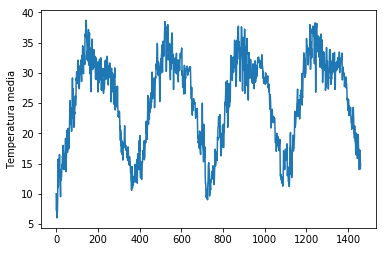

In [8]:
import matplotlib.pyplot as plt

plt.plot(df.index, df["meantemp"])
plt.xlabel(" ")
plt.ylabel("Temperatura media")

(975, 1075.0)

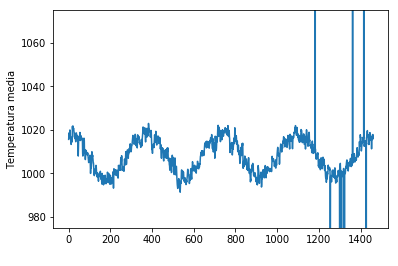

In [6]:
plt.plot(df.index, df["meanpressure"])
plt.xlabel(" ")
plt.ylabel("Temperatura media")
plt.ylim(top=1075)
plt.ylim(bottom=975)

> b) Entrene un solo Árbol de Regresión de múltiples niveles para resolver el problema. Defina un Árbol **no regularizado** (como el que no tiene límites en su profundidad) y otro Árbol **regularizado** (variando los hiper-parámetros que prefiera, por ejemplo, los más comunes como la profundidad, el número mínimo de datos para realizar *split* o el número mínimo de datos en cada hoja). Además comente sobre la ventaja de usar un árbol de decisión respecto a la escala de los datos ¿Porqué no es necesario escalar los datos?

In [21]:
from sklearn.tree import DecisionTreeRegressor as Tree

def do_Tree(X, Y, max_depth=None, min_samples_split=1.0):
    model = Tree()
    model.set_params(max_depth=max_depth, min_samples_split=min_samples_split)
    model.fit(X, Y)
    return model

model_nr = do_Tree(X_train, Y_train)

model_r_10_05 = do_Tree(X_train, Y_train, 10,min_samples_split=0.03) 

> c) Para evaluar la calidad de predicción en este problema se utilizará la métrica *Root Mean Squared Error* (RMSE), indicando un error en la escala real de la temperatura. Como los datos de validación siguen con el orden temporal, visualice esa predicción a lo largo del tiempo. Comente sobre los resultados comparando la regularización *vs* el no regularizar.

RMSE train=  3.567413761517928
RMSE val=  3.9221739709003955


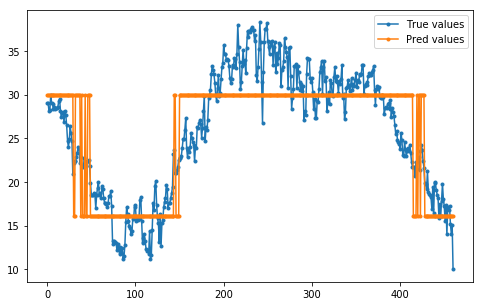

In [15]:
import numpy as np
import matplotlib.pyplot as plt
def RMSE(ytrue,ypred):
    return np.sqrt(np.mean(np.square(ytrue - ypred)) )

y_train_hat = model_nr.predict(X_train)
y_val_hat = model_nr.predict(X_val)
print("RMSE train= ",RMSE(Y_train,y_train_hat))
print("RMSE val= ",RMSE(Y_val,y_val_hat))

plt.figure(figsize=(8,5))
plt.plot(Y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.legend()
plt.show()

RMSE train=  1.361154604963584
RMSE val=  1.8974147068365599


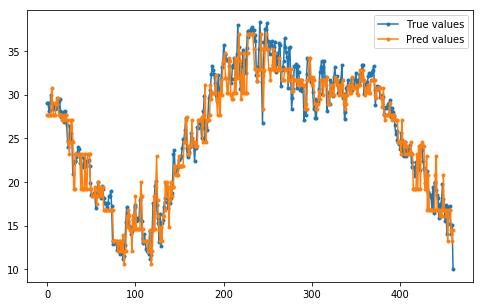

In [22]:
y_train_hat = model_r_10_05.predict(X_train)
y_val_hat = model_r_10_05.predict(X_val)
print("RMSE train= ",RMSE(Y_train,y_train_hat))
print("RMSE val= ",RMSE(Y_val,y_val_hat))

plt.figure(figsize=(8,5))
plt.plot(Y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.legend()
plt.show()

> d) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de **Bagging**, compare el Árbol **no regularizado** con el **regularizado** (*seteando los hiper-parámetros en base a lo experimentado anteriormente en b)*) ¿Qué debería suceder? ¿Se visualiza *overfitting*? Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.

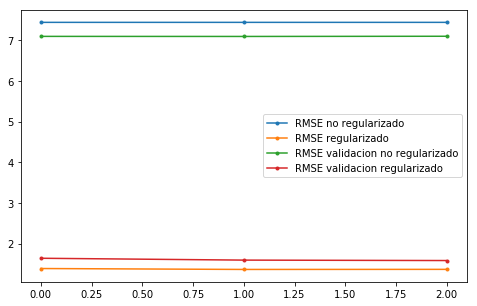

In [31]:
from sklearn.ensemble import BaggingRegressor

def do_Bagging(X, Y, max_depth=None, min_samples_split=1.0, n=10):
    tree = Tree()
    tree.set_params(max_depth=max_depth, min_samples_split=min_samples_split)
    model = BaggingRegressor(base_estimator=tree, n_estimators=n, n_jobs=-1)
    model.fit(X, Y)
    return model

models_bnr = list()
models_br = list()

for i in [2, 4, 8, 32, 64, 128]:
    models_bnr.append(do_Bagging(X_train, Y_train, n=i))
    models_br.append(do_Bagging(X_train, Y_train, max_depth=10, min_samples_split=0.03, n=i))

values_br_train = list()
values_br_val = list()
for i in models_br:
    y_train_hat = i.predict(X_train)
    y_val_hat = i.predict(X_val)
    values_br_train.append(RMSE(Y_train,y_train_hat))
    values_br_val.append(RMSE(Y_val,y_val_hat))
    
values_bnr_train = list()
values_bnr_val = list()
for i in models_bnr:
    y_train_hat = i.predict(X_train)
    y_val_hat = i.predict(X_val)
    values_bnr_train.append(RMSE(Y_train,y_train_hat))
    values_bnr_val.append(RMSE(Y_val,y_val_hat))
    
plt.figure(figsize=(8,5))
plt.plot(values_bnr_train, '.-' ,label="RMSE no regularizado")
plt.plot(values_br_train, '.-' ,label="RMSE regularizado")
plt.plot(values_bnr_val, '.-' ,label="RMSE validacion no regularizado")
plt.plot(values_br_val, '.-' ,label="RMSE validacion regularizado")
plt.legend()
plt.show()

> e) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de **AdaBoost**, compare el Árbol **no regularizado** con el **regularizado** (*seteando los hiper-parámetros en base a lo experimentado anteriormente en d)* ¿Se visualiza *overfitting*? ¿Qué técnica utiliza la librería de sklearn, *re-muestrear* o *pesar* ejemplos? ¿Qué le parece más sensato?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro. Compare y analice con la técnica utilizada en d).

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
model = AdaBoostRegressor(base_estimator=Tree(...), n_estimators=...)

> f) Pruebe otra técnica de ensamblado dedicada a árboles de decisión, que combina el muestreo *boostrap* de *Bagging* con muestreo sobre las *features*: **Random Forest**, compare el Árbol **no regularizado** con el **regularizado** ¿Se visualiza *overfitting*?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model_unr = RandomForestRegressor(n_estimators=..., n_jobs=-1)
... #define your regularized random forest model

> g) Verifique que el **OOB error** (*out of bag error*) de los ensambladores que utilizan la técnica *boostrap* puede ser una alternativa como métrica de generalización, compare con el error calculado sobre el conjunto de validación (o en su defecto *cross validation*).

In [ ]:
oob_error = model.oob_score_
val_error = model.score(X_val,y_val)
print("OOB error: ",oob_error)
print ("Val error: ",val_error)

> h) Defina otra forma de combinar los valores que entregan los ensamblados al hacer predicciones y compare con lo que se hace actualmente, por ejemplo *Bagging* realiza el voto de la mayoría para clasificación y promedio para regresión, *AdaBoost* realiza una combinación ponderada de cada clasificador dependiendo de su *habilidad* (desempeño para clasificar el conjunto de entrenamiento). Se puede inspirar desde clásicos estadísticos, como entregar el primer cuartíl ($Q_1$) si al ensamblado le cuesta predecir valores bajos, o el segundo cuartil ($Q_2$) o mediana para ser robusto a predicciones atípicas de modelos.  

In [ ]:
def combine_predictions(predictions):
    return #define !
list_estimators = model.estimators_
list_predictions = [estimator.predict(X_val) for estimator in list_estimators]
new_predictions = combine_predictions(list_predictions)
print("RMSE val= ",RMSE(y_val, new_predictions))

> i) Si se cuenta con una gran cantidad de modelos en el ensamblado, por ejemplo $T>100$, se puede crear un intervalo de confianza de la predicción a través de todos estos valores, asumiendo una distribución Normal centrada en la media muestral de las predicciones, con desviación estándar muestral en las predicciones. El intervalo de confianza entrega más información que un único valor puntual de predicción. Visualice un intervalo de confianza al 95% de probabilidad en la predicción a lo largo de la serie de tiempo de validación, comente. Al asumir una distribución Normal, también puede explorar el tomar como predicción del ensamblado el muestreo sobre la distribución Normal creada entorno a los datos muestrales.

In [ ]:
X_val_est = np.vstack(list_predictions).T #has shape=(N_test, n_estimator), with n_estimator>100
from scipy.stats import norm
interv_val = []
for n in range(X_val.shape[0]):
    low, up = norm.interval(0.95, loc=np.mean(X_val_est[n]), scale=np.std(X_val_est[n]))
    interv_val.append([low,up])
interv_val = np.asarray(interv_val)
x = np.arange(X_val_est.shape[0])
plt.figure(figsize=(8,5))
plt.plot(x, np.mean(X_val_est, axis=1))
plt.fill_between(x, interv_val[:,0], interv_val[:,1], color='r', alpha=.55)
plt.show()

>  j) Evalúe y visualice la predicción del mejor modelo encontrado para resolver este problema, en el conjunto de pruebas. Además, compare y analice las distintas maneras con las que se resolvió el problema, incluya las decisiones que conlleva y los resultados que reflejan.

In [ ]:
df = pd.read_csv("DailyDelhiClimateTest.csv")

<a id="refs"></a>
## Referencias
[1] https://scikit-learn.org/stable/modules/ensemble.html  
[2] https://scikit-learn.org/stable/modules/tree.html  
[3] http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html  
[4] https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18